In [109]:
#---Import Data Handling Modules---#
import numpy as np
import pandas as pd
import datetime as datetime
import itertools as it
import re

#---Import Comp/Python Modules---#
import os
import codecs
import warnings

#---Import NLP Modules---#
import spacy
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim
from sklearn.manifold import TSNE


#---Import Visualizations Packages---#
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly
import plotly.graph_objs as go

%matplotlib inline
nlp = spacy.load('en')

In [2]:
Groupons = pd.read_csv('groupon_deals_fixed.csv',)
all_groupon_reviews = pd.read_csv('all_groupon_reviews.csv')
del Groupons['Unnamed: 0']
del all_groupon_reviews['Unnamed: 0']
del Groupons['state']

In [3]:
all_groupon_reviews = all_groupon_reviews.dropna()

In [4]:
all_groupon_reviews['date'] = all_groupon_reviews.date.apply(pd.to_datetime)

In [186]:
tst = all_groupon_reviews.groupby(['year', 'month'], as_index=False).agg('count')
tst['day2'] = 1
tst['new_date'] = tst.apply(lambda x: str(x.year) + '/' + str(x.month) + '/' + str(x.day2), axis = 1)


# init_notebook_mode()
data = [go.Scatter(x = tst.new_date, y = tst.author)]
plotly.offline.plot(data)

'file:///Users/nicholasmaloof/Documents/Python_NLP/temp-plot.html'

(-1.1250927628939771, 1.10857368289159, -1.106787774973695, 1.1071334320070587)

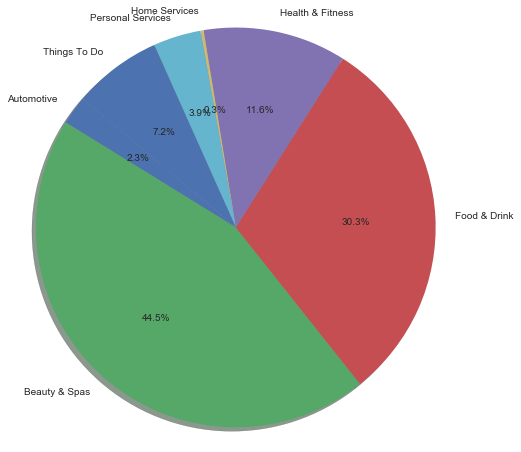

In [6]:
pie_chart_df = Groupons.groupby('categories').agg('count')

plt.rcParams['figure.figsize'] = (8,8)

sizes = list(pie_chart_df.mini_info)
labels = pie_chart_df.index
plt.pie(sizes, shadow=True, labels = labels, autopct='%1.1f%%', startangle=140)
# plt.legend(labels, loc="best")
plt.axis('equal')

In [9]:
def find_prices(text, lo_ma = 0):
    m = re.findall("\\$[0-9]+[.,]?[0-9]*", text)
    if m == []:
        m = re.findall('\\$[0-9]+', text)
    low = m[0::2]
    low = [i.replace(',','') for i in low]
    high = m[1::2]
    high = [i.replace(',', '') for i in high]
    if lo_ma == 0:
        return low
    elif lo_ma == 1:
        return high

In [10]:
Groupons['low_off'] = Groupons.apply(lambda x: find_prices(x.deal_features, lo_ma = 0), axis = 1)
Groupons['high_off'] = Groupons.apply(lambda x: find_prices(x.deal_features, lo_ma = 1), axis = 1)

Groupons['low_off'] = Groupons.apply(lambda x: [i.replace('$', '') for i in x.low_off], axis = 1)
Groupons['high_off'] = Groupons.apply(lambda x: [i.replace('$', '') for i in x.high_off], axis = 1)

In [11]:
offer_counts = {'0': 0, '1' :0, '2': 0, '3':0, '4':0, '5': 0, '6':0, '7':0, '10':0}
for i in Groupons.low_off:
    l = len(i)
    offer_counts[str(l)] = offer_counts[str(l)] + 1

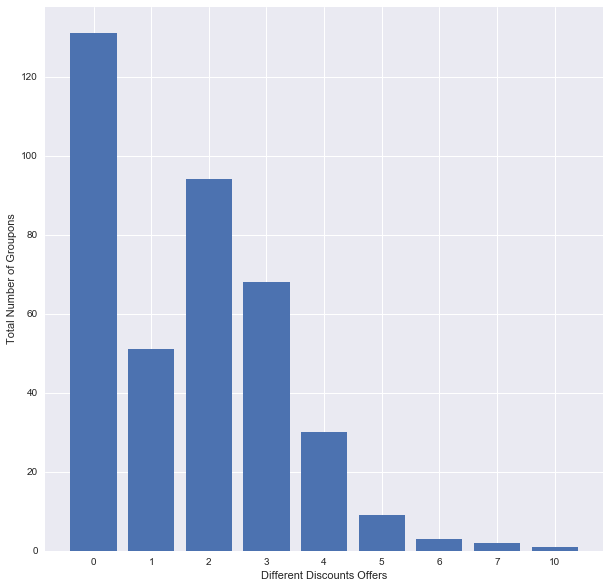

In [187]:
plt.rcParams['figure.figsize'] = (10,10)

objects = list(offer_counts.keys())
y = list(offer_counts.values())
tst = np.arange(len(y))

plt.bar(tst,y, align = 'center')
plt.xticks(tst, objects)
plt.ylabel('Total Number of Groupons')
plt.xlabel('Different Discounts Offers')
plt.show()

In [13]:
Groupons['num_offerings'] = Groupons.apply(lambda x: len(x.low_off), axis = 1)

In [14]:
categ_count = Groupons.groupby(['categories', 'num_offerings'],as_index=False).deal_features.count()

In [15]:
# sns.barplot(x = 'categories', y = 'deal_features', data = categ_count, hue = 'num_offerings')

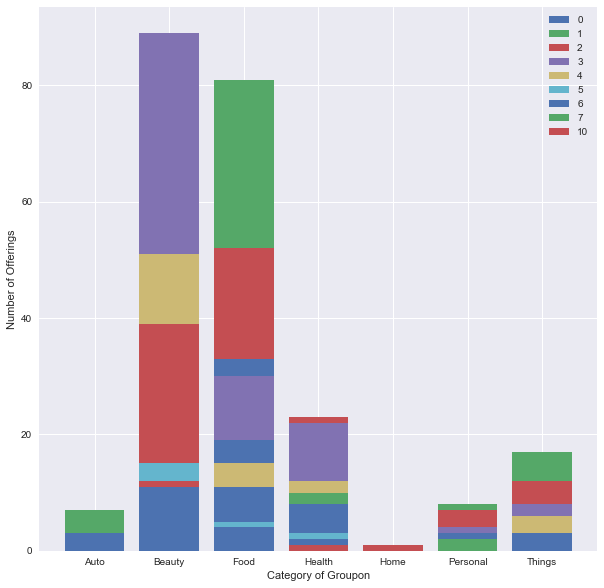

In [16]:
#        Au  Be Fo  He, Ho, Pe Th
zeros = [3, 58, 48, 8, 0, 4, 10]
ones = [4, 11, 33, 11, 0, 4, 7]
twos = [0, 50, 19, 12, 1, 3, 5]
threes = [1, 39, 11, 10, 0, 1, 3]
fours = [0, 12, 4, 2, 0, 1, 3]
fives = [0, 3, 1, 1, 0, 0, 0]
sixes = [1, 0, 2, 0, 0, 0, 0]
sevens = [0, 0, 0, 0, 0, 2, 0]
tens = [0, 0, 0, 1, 0, 0, 0]

ind = np.arange(7)
p0 = plt.bar(ind, zeros)
p1 = plt.bar(ind, ones, bottom = zeros)
p2 = plt.bar(ind, twos, bottom = ones)
p3 = plt.bar(ind, threes, bottom = twos)
p4 = plt.bar(ind, fours, bottom = threes)
p5 = plt.bar(ind, fives, bottom = fours)
p6 = plt.bar(ind, sixes, bottom = fives)
p7 = plt.bar(ind, sevens, bottom = sixes)
p10 = plt.bar(ind, tens, bottom = sevens)

plt.ylabel('Number of Offerings')
plt.xticks(ind, ('Auto', 'Beauty', 'Food', 'Health', 'Home', 'Personal', 'Things'))
plt.xlabel('Category of Groupon')
plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p10[0]), ('0', '1', '2', '3', '4', '5', '6', '7', '10'))

/Users/nicholasmaloof/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



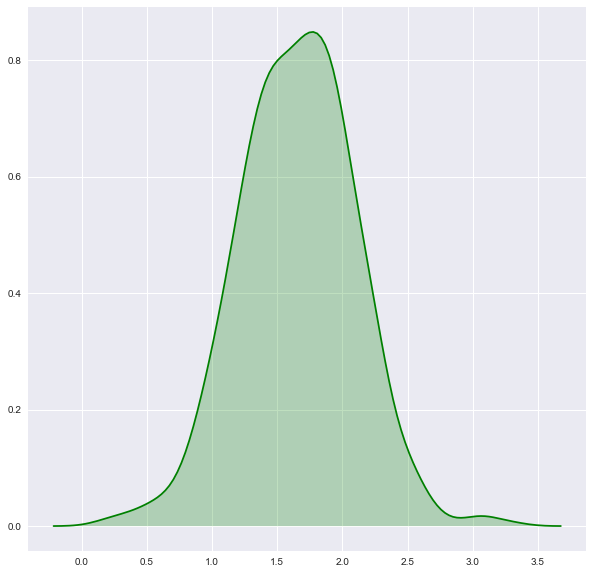

In [44]:
savings = []
for l, h in zip(list(Groupons.low_off), list(Groupons.high_off)):
    for i in range(min(len(l), len(h))):
        sav = float(h[i]) - float(l[i])
        savings.append(sav)
savings = [i for i in savings if i > 0]
sns.distplot([np.log10(i) for i in savings], hist=False, color="g", kde_kws={"shade": True})

In [104]:
auto_reviews = Groupons.loc[Groupons.categories == 'Automotive',:]
beauty_reviews = Groupons.loc[Groupons.categories == "Beauty & Spas",:]
food_reviews = Groupons.loc[Groupons.categories == "Food & Drink",:]
health_reviews = Groupons.loc[Groupons.categories == "Health & Fitness",:]
home_reviews = Groupons.loc[Groupons.categories == "Home Services",:]
personal_reviews = Groupons.loc[Groupons.categories == "Personal Services",:]
things_reviews = Groupons.loc[Groupons.categories == "Things To Do", :]

auto_sav = []
for l,h in zip(list(auto_reviews.low_off), list(auto_reviews.high_off)):
    for i in range(min(len(l), len(h))):
        sav = float(h[i]) - float(l[i])
        auto_sav.append(sav)

beauty_sav = []
for l,h in zip(list(beauty_reviews.low_off), list(beauty_reviews.high_off)):
    for i in range(min(len(l), len(h))):
        sav = float(h[i]) - float(l[i])
        beauty_sav.append(sav)
        
food_sav = []
for l,h in zip(list(food_reviews.low_off), list(food_reviews.high_off)):
    for i in range(min(len(l), len(h))):
        sav = float(h[i]) - float(l[i])
        food_sav.append(sav)
        

health_sav = []
for l,h in zip(list(health_reviews.low_off), list(health_reviews.high_off)):
    for i in range(min(len(l), len(h))):
        sav = float(h[i]) - float(l[i])
        health_sav.append(sav)

home_sav = []
for l,h in zip(list(home_reviews.low_off), list(home_reviews.high_off)):
    for i in range(min(len(l), len(h))):
        sav = float(h[i]) - float(l[i])
        home_sav.append(sav)

personal_sav = []
for l,h in zip(list(personal_reviews.low_off), list(personal_reviews.high_off)):
    for i in range(min(len(l), len(h))):
        sav = float(h[i]) - float(l[i])
        personal_sav.append(sav)

things_sav = []        
for l,h in zip(list(things_reviews.low_off), list(things_reviews.high_off)):
    for i in range(min(len(l), len(h))):
        sav = float(h[i]) - float(l[i])
        things_sav.append(sav)        
        
auto_sav = [i for i in auto_sav if i > 0]
beauty_sav = [i for i in beauty_sav if i > 0]
food_sav = [i for i in food_sav if i > 0]
health_sav = [i for i in health_sav if i > 0]
home_sav = [i for i in home_sav if i > 0]
personal_sav = [i for i in personal_sav if i > 0]
things_sav = [i for i in things_sav if i >0]

long1 = pd.DataFrame(auto_sav)
long2 = pd.DataFrame(beauty_sav)
long3 = pd.DataFrame(food_sav)
long4 = pd.DataFrame(health_sav)
long5 = pd.DataFrame(home_sav)
long6 = pd.DataFrame(personal_sav)
long7 = pd.DataFrame(things_sav)

savings_dataframe = pd.concat([long1, long2, long3, long4, long5, long6, long7], ignore_index=True, axis =1)
savings_dataframe = pd.DataFrame(savings_dataframe)
savings_dataframe.columns = ['Auto', 'Beauty', 'Food', 'Health', 'Home', 'Personal', 'Things']

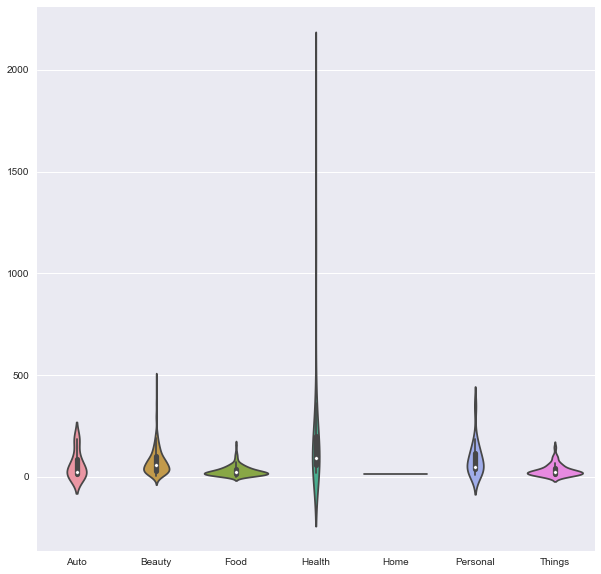

In [105]:
sns.violinplot(data = savings_dataframe)

In [167]:
def lemmatize_words(dataframe, column):
    words = ""
    for review in dataframe[column]:
        text = review.lower()
        parsed_review = nlp(text)
        parsed_review = [token.lemma_ for token in parsed_review if not token.is_punct and not token.is_space]
        parsed_review = [token for token in parsed_review if token not in spacy.en.English.Defaults.stop_words]
        parsed_review = [token for token in parsed_review if token != '-PRON-']
        words += ' '.join(parsed_review)
    return words
text = lemmatize_words(all_groupon_reviews, 'content')

CPU times: user 14 s, sys: 2.01 s, total: 16 s
Wall time: 16.1 s


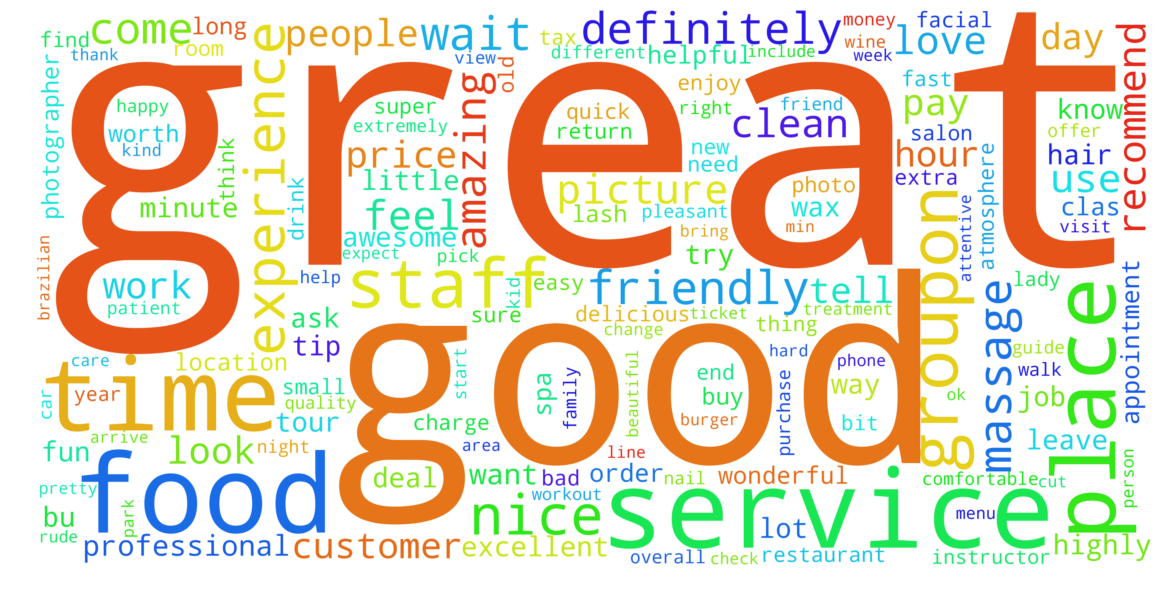

In [185]:
%%time
plt.rcParams['figure.figsize'] = (20,20)
wordcloud = WordCloud(width=4000, height=2000, max_words=150, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [161]:
lemmatize_words(all_groupon_reviews, 'content')

['joseph', 'wonderful', 'disposition', 'ease', 'immediately', 'ask', 'question', 'listen', 'feel', 'genuinely', 'concerned', 'address', 'issue', 'place', 'beautifully', 'serene', 'neatly', 'design', 'immaculate', 'certainly', 'sterile', 'detached', 'relaxed', 'think', 'snore', 'second', 'feel', 'great', 'return', 'sure']


NameError: name '__file__' is not defined